# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
%matplotlib inline

from itertools import product
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score, mean_absolute_error

# Input dataset

In [2]:
data = pd.read_csv("Data/Lake_Bilancino.csv", index_col = ['Date'], parse_dates=['Date'])

# Data analysis and processing

In [3]:
data.head()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2002-03-06,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-04-06,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-05-06,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-06,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-07-06,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [4]:
data.shape

(6603, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6603 entries, 2002-03-06 to 2020-06-30
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rainfall_S_Piero      6026 non-null   float64
 1   Rainfall_Mangona      6026 non-null   float64
 2   Rainfall_S_Agata      6026 non-null   float64
 3   Rainfall_Cavallina    6026 non-null   float64
 4   Rainfall_Le_Croci     6026 non-null   float64
 5   Temperature_Le_Croci  6025 non-null   float64
 6   Lake_Level            6603 non-null   float64
 7   Flow_Rate             6582 non-null   float64
dtypes: float64(8)
memory usage: 464.3 KB


In [6]:
data.isnull().sum()

Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64

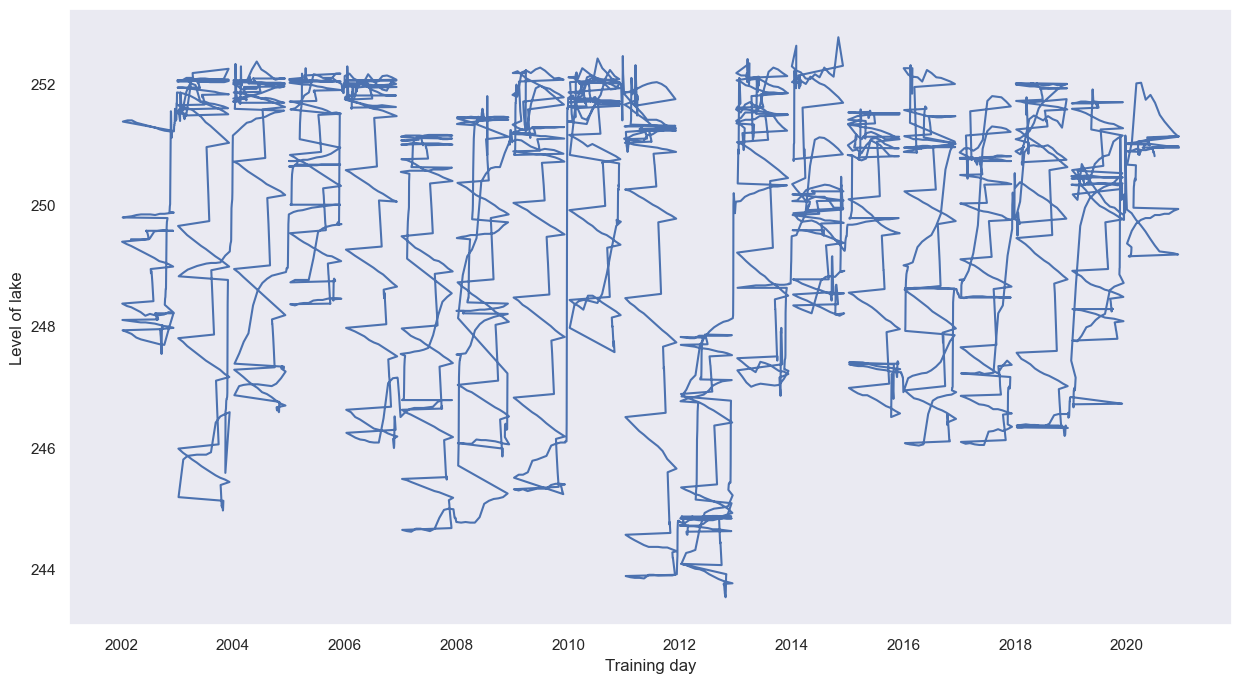

In [7]:
plt.figure(figsize=(15,8))
plt.plot(data.Lake_Level)
plt.xlabel("Training day")
plt.ylabel("Level of lake")
plt.grid(False)
plt.show()

# Moving Average

In [8]:
def moving_avg_plot(attribute,window):
    plt.figure(figsize=(15,8))
    plt.plot(attribute[window:], label="Actual")
    
    rolling_mean=attribute.rolling(window=window).mean()
    plt.plot(rolling_mean,'g', label="Rolling mean average")
    
    plt.grid(True)

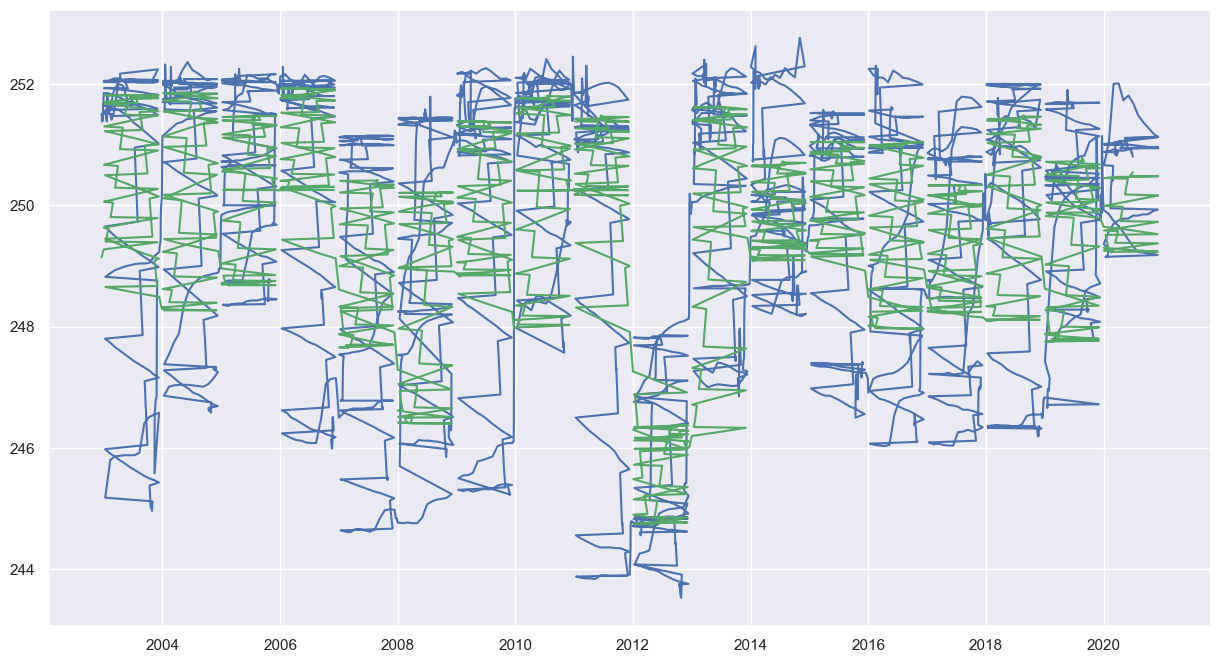

In [9]:
moving_avg_plot(data.Lake_Level, 200)

# Exponential smoothing

In [10]:
def exponential_smoothing(column,alpha):
    result=[column[0]]
    
    for n in range(1, len(column)):
        old=alpha*column[n]+(1-alpha)*result[n-1]
        result.append(old)
        
    return result

In [11]:
def exponential_smoothing_plot(column,alpha):
    plt.figure(figsize=(15,8))
    for a in alpha:
        plt.plot(exponential_smoothing(column,a), label=f"Alpha{a}")
        
    plt.plot(column.values,"c",label="Actual")
    plt.legend(loc="best")
    plt.grid(True)

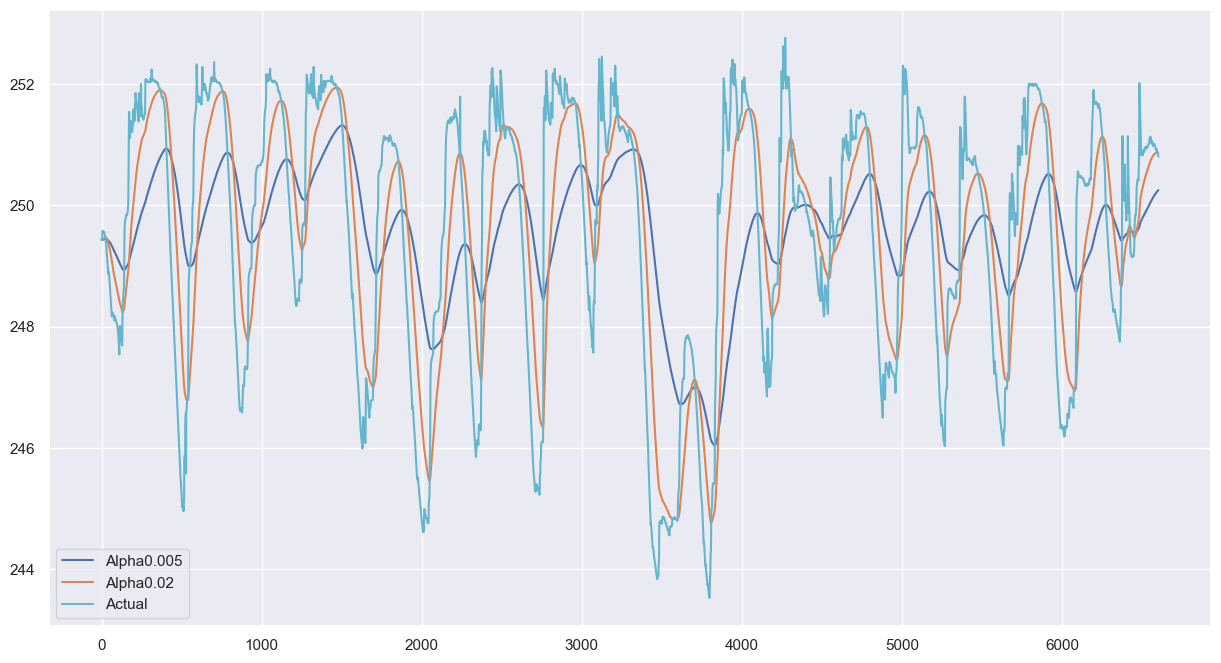

In [12]:
exponential_smoothing_plot(data.Lake_Level,[0.005,0.02])

In [13]:
def double_exponential_smoothing(column,alpha,beta):
    result=[column[0]]
    
    for n in range(1, len(column)+1):
        if n==1:
            level,trend = column[0], column[1]-column[0]
            
        if n>=len(column):
            value = result[-1]
            
        else:
            value = column[n]
            
        last_level, level = level,alpha*value + (1-alpha)*(level+trend)
        trend = beta * (level-last_level) + (1-beta)*trend
        
        result.append(level+trend)
        
    return result

In [14]:
def double_exponential_smoothing_plot(column,alpha,beta):
    plt.figure(figsize=(15,8))
    for a in alpha:
        for b in beta:
            plt.plot(double_exponential_smoothing(column,a,b), label=f"Alpha {a}, Beta {b}")
        
    plt.plot(column.values,"c",label="Actual")
    plt.legend(loc="best")
    plt.grid(True)

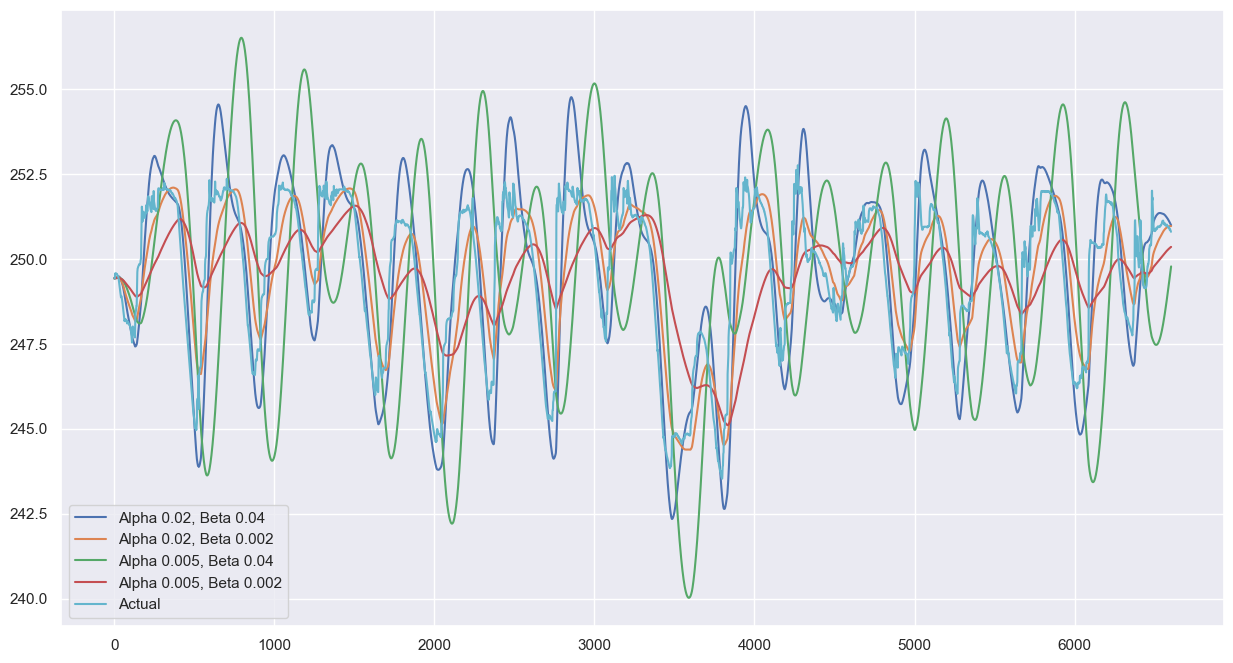

In [15]:
double_exponential_smoothing_plot(data.Lake_Level,alpha=[0.02,0.005], beta=[0.04,0.002])

# Dicky Fuller Test

In [16]:
def tsplot(y, lags=None, figsize=(15,8), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout=(2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Dicky-Fuller: p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

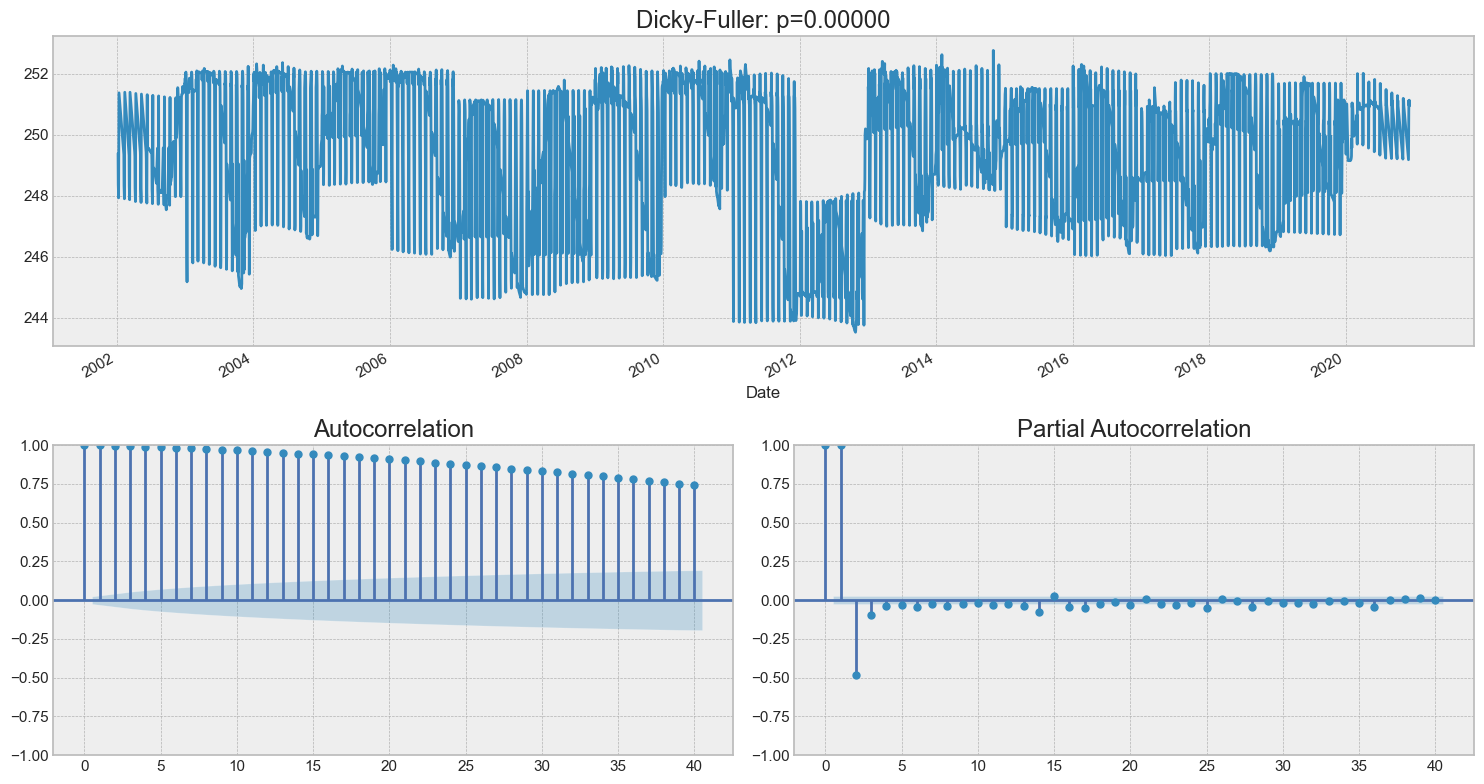

In [17]:
tsplot(data.Lake_Level, lags=40)

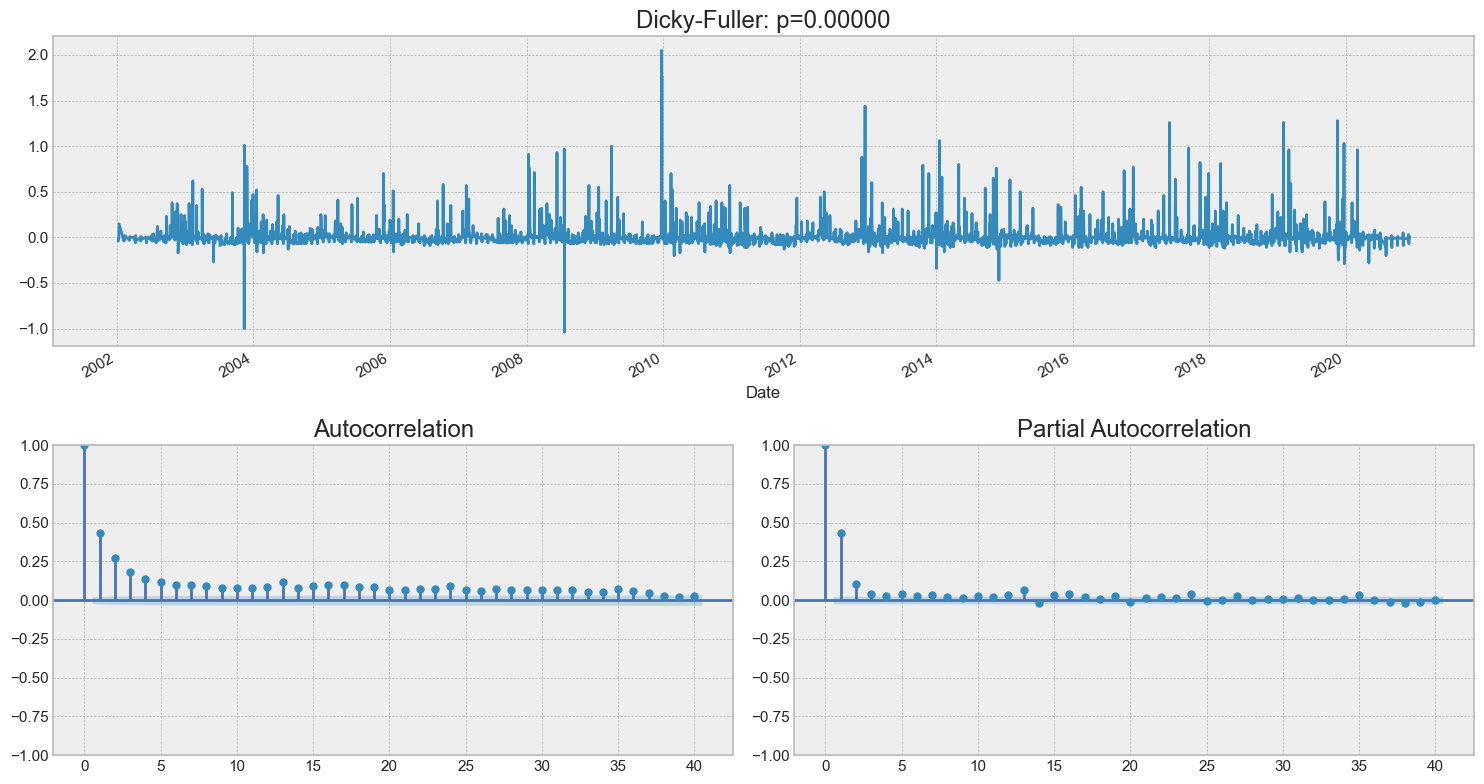

In [18]:
temp = data.Lake_Level-data.Lake_Level.shift(1)
tsplot(temp[1:], lags=40 )

# Predictive Modeling

In [19]:
p = range(0,3)
d = 1
q = range(0,3)
P = range(0,3)
Q = range(0,3)
D = 1
s = 5

parameters= product(p,q,P,Q)
parameter_list = list(parameters)

In [20]:
len(parameter_list)

81

In [21]:
def SARIMA(parameter_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for p in parameter_list:
        model = sm.tsa.statespace.SARIMAX(data.Lake_Level, order=(p[0], d, p[1]), seasonal_order=(p[2],D,p[3],s)).fit()
        
        aic = model.aic
        
        if aic<best_aic:
            best_model = model
            best_aic = aic
            best_parameter = p
            
        results.append([p,model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ["Parameters", "AIC"]
    
    result_table = result_table.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    return result_table
    

In [22]:
result_table = SARIMA(parameter_list,d,D,s)

In [23]:
result_table.Parameters[0]

(2, 1, 1, 1)

In [24]:
p,q,P,Q = result_table.Parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Lake_Level, order=(p,q,d), seasonal_order=(P,Q,D,s)).fit()
                                       
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        Lake_Level   No. Observations:                 6603
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 5)   Log Likelihood                6282.846
Date:                           Tue, 18 Apr 2023   AIC                         -12553.692
Time:                                   22:07:52   BIC                         -12512.926
Sample:                                        0   HQIC                        -12539.603
                                          - 6603                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3077      0.010    130.289      0.000       1.288       1.327
ar.L2         -0.3294      0.006    -51.003

# Visualization

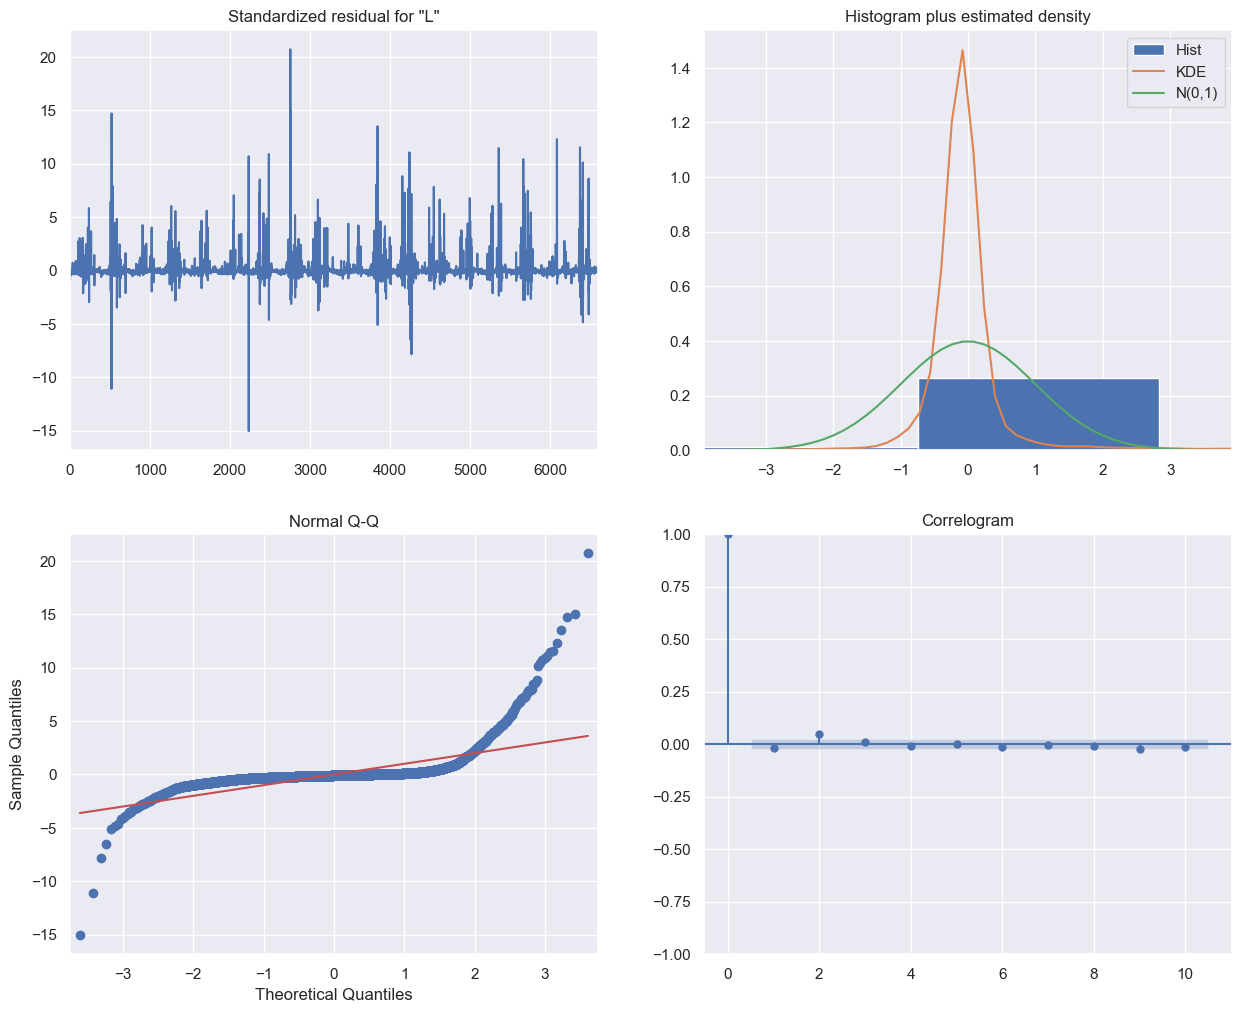

In [25]:
best_model.plot_diagnostics(figsize=(15,12));

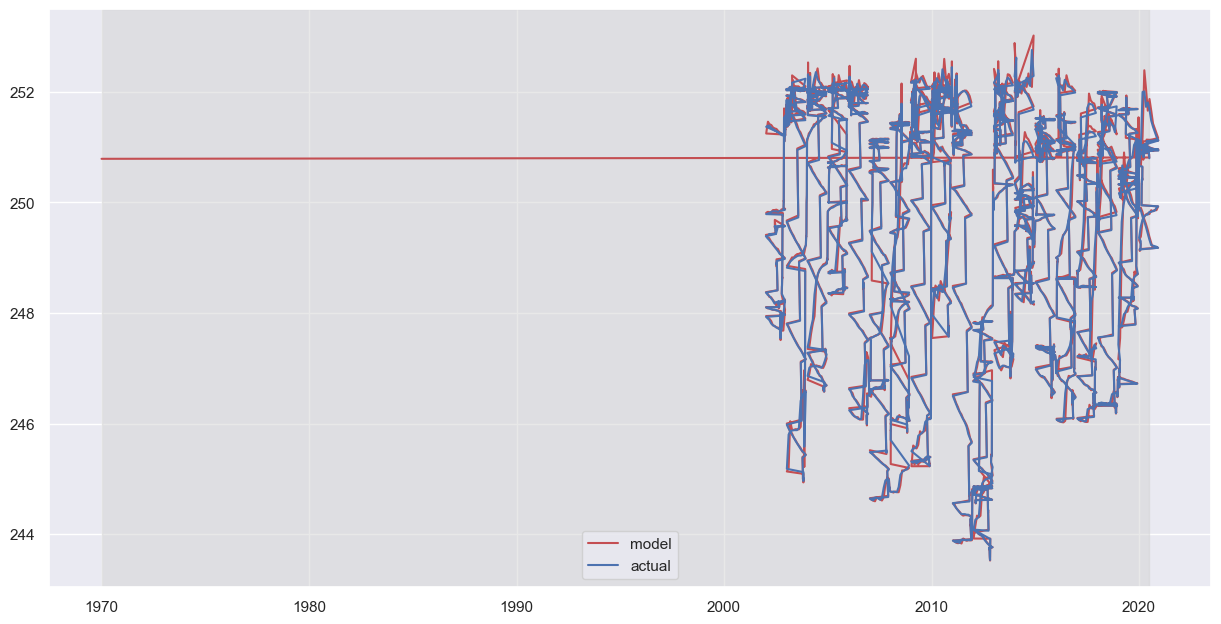

In [26]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:6] = np.NaN
forecast = best_model.predict(start=data.shape[0], end=data.shape[0])
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['Lake_Level'], label='actual')
plt.legend()
plt.show()

In [27]:
def mean_absolute_parcentage_error(y_true, y_predicted):
    return np.mean(np.abs((y_true-y_predicted)/y_true))*100

In [28]:
mean_absolute_parcentage_error(data.Lake_Level[s+d:], best_model.fittedvalues[s+d:])

0.013627916499025049